In [13]:
from pybaseball import schedule_and_record
from pybaseball import team_batting

batting = team_batting(2023).add_prefix('batting.')
year = 2023
games_in_regular_season = 162

In [2]:
team_ids = list(batting['batting.Team'].values)

In [3]:
import time
records_by_team = {}
for team_id in team_ids:
    records_by_team[team_id] = schedule_and_record(year, team_id)
    time.sleep(5)

http://www.baseball-reference.com/teams/ATL/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/TEX/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/LAD/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/TBR/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/HOU/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/PHI/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/CHC/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/BOS/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/MIN/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/SDP/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/BAL/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/CIN/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/TOR/2023-schedule-scores.shtml
http://www.baseball-reference.com/teams/STL/2023-schedule-scores.shtml
http:/

In [22]:
import numpy as np
# only include games that have a time
all_game_times = []
num_games_with_times = 0
num_games_with_no_times = 0
total_num_games_scheduled = 0
for [team, team_record] in records_by_team.items():
    #for i in range(len(team_record)):
    # changed to exclude post-season games
    for i in range(games_in_regular_season):
        # don't double count games; do this by excluding records of away games
        if team_record.iloc[i]['Home_Away'] != 'Home':
            continue
        game_time_str = team_record.iloc[i]['Time']
        if game_time_str:
            game_time_list = game_time_str.strip().split(':')
            game_time_h = game_time_list[0]
            game_time_m = game_time_list[1]
            game_time_mins = (float(game_time_h) * 60) + float(game_time_m)
            num_games_with_times += 1
            innings = float(team_record.iloc[i]['Inn'])
            all_game_times.append([game_time_mins, innings])
        else:
            num_games_with_no_times += 1
        total_num_games_scheduled += 1

pct_complete = 100.0 * num_games_with_times / total_num_games_scheduled
# assume no forfeits
games_remaining = num_games_with_no_times

In [23]:
def game_time_average_mins_for_nine_inning_games(game_times):
    game_times_for_nine_inning_games = []
    for [game_time,innings] in game_times:
        if innings == 9.0:
            game_times_for_nine_inning_games.append(game_time)
    return np.average(game_times_for_nine_inning_games)

game_time_average_mins = game_time_average_mins_for_nine_inning_games(all_game_times)

In [24]:
print(f"{num_games_with_times} / {total_num_games_scheduled} games completed ({pct_complete:.4f} %)")
print(f"{games_remaining} games remaining")
print(f"Game time average for 9-inning games: {game_time_average_mins:.4f} minutes")

2358 / 2430 games completed (97.0370 %)
72 games remaining
Game time average for 9-inning games: 159.8570 minutes


In [25]:
import random

# Number of bootstrap samples to generate
num_samples = 100000

# Calculate the statistic of interest (e.g., mean) for the original data
original_statistic = game_time_average_mins

# Initialize an array to store resampled statistics
resampled_statistics = np.empty(num_samples)

# Range of values for CDF estimation
values_of_interest = list(np.around(np.arange(158.0, 162.1, 0.1), 1))

# Initialize an array to store CDF from bootstraps
binary_outcomes = np.empty((num_samples, len(values_of_interest)))

# Perform bootstrapping
for i in range(num_samples):
    # Generate a resampled dataset by sampling with replacement to extend the current one
    # since it is not 1-D, we need to use indices
    random_indices = random.choices(list(range(len(all_game_times))), k=games_remaining)
    # Use the selected keys to access corresponding values
    resampled_data = all_game_times + [all_game_times[i] for i in random_indices]

    # Calculate the statistic of interest for the resampled dataset
    resampled_statistic = game_time_average_mins_for_nine_inning_games(resampled_data)
    
    # Store the resampled statistic
    resampled_statistics[i] = resampled_statistic

    # Threshold on the values of interest using the expected ACE
    binary_outcome = []
    for value in values_of_interest:
        if resampled_statistic < value:
            binary_outcome.append(0)
        else:
            binary_outcome.append(1)
    binary_outcomes[i] = binary_outcome
    
# Calculate the CDF for each value of interest (using the average of the thresholded binary outcomes)
cdf = np.mean(binary_outcomes, axis=0)


Probability of game time of 160 mins using bootstrapping: 1.27 %


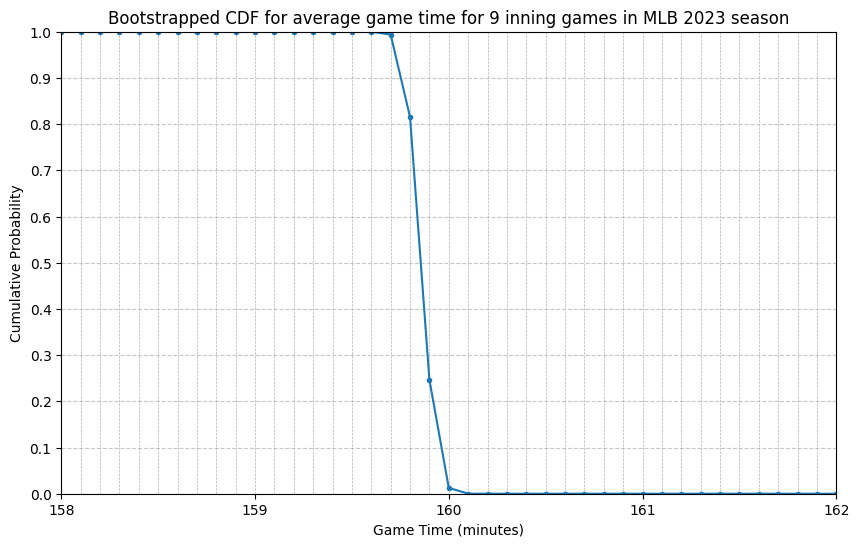

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

print("")
print(f"Probability of game time of 160 mins using bootstrapping: {cdf[values_of_interest.index(160.0)]*100:2.2f} %")

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(values_of_interest, cdf, marker='.', linestyle='-')

plt.xlabel('Game Time (minutes)')
plt.ylabel('Cumulative Probability')
plt.title(f'Bootstrapped CDF for average game time for 9 inning games in MLB {year} season')

# Set y-axis limits to 0.0 and 1.0
plt.ylim(0.0, 1.0)

# Customize y-axis ticks and grid lines at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))

# Define major tick positions and labels
major_tick_positions = list(range(158, 163))

# Set major ticks and labels
plt.xticks(major_tick_positions)

# Create a minor tick locator for intervals of 0.1
minor_locator = MultipleLocator(0.1)

# Set minor ticks without labels
plt.gca().xaxis.set_minor_locator(minor_locator)
plt.tick_params(axis='x', which='minor', bottom=False)

# Add vertical grid lines at minor tick positions
plt.grid(True, which='minor', axis='x', linestyle='--', color='gray', alpha=0.6, linewidth=0.5)

plt.xlim(158, 162)

# Add vertical grid lines at minor tick positions
plt.gca().xaxis.grid(True, linestyle='--', color='gray', alpha=0.6, linewidth=0.5)

# Show the plot
#plt.show()

plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)

#plt.grid(True)
#plt.show()
    